# **CA6 - Clustring**
# Amirmahdi Farzane
# 810100194

In [ ]:
!pip install hazm

In [1]:
import gensim
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # Import tqdm
import pandas as pd
import hazm

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/CA6-Clustring')

Mounted at /content/drive


#Q1

In an imbalanced dataset, the low density of one class may result in insufficient clustering, while a high density of another class can create a dense area, making it more likely for cluster centers to be located there, potentially causing the model's accuracy to decrease.

Identifying data imbalance is challenging, especially when labels are unknown. Addressing this issue is more complex than in classification tasks. If the unbalanced cluster can be identified, undersampling or oversampling techniques may be applied. Some algorithms are less sensitive to imbalanced data; in such cases, leveraging ensemble learning can be beneficial.

In [3]:
import pandas as pd

TRAIN_FILE_PATH = "./train.csv"
TEST_FILE_PATH = "./test.csv"

train_df = pd.read_csv(TRAIN_FILE_PATH)
test_df = pd.read_csv(TEST_FILE_PATH)

Number of examples in each class for test and train dataframes.

In [4]:
class_column = train_df.columns[0]

# Use a for loop to count occurrences of each class
class_counts = {}
for class_name, count in train_df[class_column].value_counts().items():
    class_counts[class_name] = count

print(class_counts)

{'فناوری': 1500, 'ورزشی': 1500, 'حوادث': 1500, 'سلامت': 1500, 'سیاسی': 1500, 'فرهنگی/هنری': 1500}


In [5]:
class_column = test_df.columns[0]

# Use a for loop to count occurrences of each class
class_counts = {}
for class_name, count in test_df[class_column].value_counts().items():
    class_counts[class_name] = count

print(class_counts)

{'حوادث': 200, 'سیاسی': 200, 'ورزشی': 190, 'فرهنگی/هنری': 180, 'سلامت': 177, 'فناوری': 168}


I used hasm as normalizer , this package has diffrent method for preprocess text data.

#**Preprocess**

In [6]:
def normalize_df(df: pd.DataFrame) -> None:
    normalizer = hazm.Normalizer()
    df['content'] = df['content'].apply(normalizer.normalize)

"""این کلاس شامل توابعی برای نرمال‌سازی متن است.

    Args:
        correct_spacing: اگر `True‍` فاصله‌گذاری‌ها را در متن، نشانه‌های سجاوندی و پیشوندها و پسوندها اصلاح می‌کند.
        remove_diacritics: اگر `True` باشد اعرابِ حروف را حذف می‌کند.
        remove_specials_chars: اگر `True` باشد برخی از کاراکترها و نشانه‌های خاص را که کاربردی در پردازش متن ندارند حذف می‌کند.
        decrease_repeated_chars: اگر `True` باشد تکرارهای بیش از ۲ بار را به ۲ بار کاهش می‌دهد. مثلاً «سلاممم» را به «سلامم» تبدیل می‌کند.
        persian_style: اگر `True` باشد اصلاحات مخصوص زبان فارسی را انجام می‌دهد؛ مثلاً جایگزین‌کردن کوتیشن با گیومه.
        persian_numbers: اگر `True` باشد ارقام انگلیسی را با فارسی جایگزین می‌کند.
        unicodes_replacement: اگر `True` باشد برخی از کاراکترهای یونیکد را با معادل نرمال‌شدهٔ آن جایگزین می‌کند.
        seperate_mi: اگر `True` باشد پیشوند «می» و «نمی» را در افعال جدا می‌کند.

    """

By means of above normalizing method we can remove unusable data from our dataset and our model can focus better on main and usable part of data for example a lot of soaces or repeated letters in each word don't have gain for extract information about text.

In [7]:
#fucntion for extract words from each sample
def tokenize_df(df: pd.DataFrame) -> None:
    word_tokenizer = hazm.WordTokenizer()
    df['content'] = df['content'].apply(word_tokenizer.tokenize)

tokenizer = WordTokenizer(join_abbreviations=True)

print(' '.join(tokenizer.tokenize('امام علی (ع) فرمود: برترین زهد، پنهان داشتن زهد است')))

 ['امام', 'علی', '(ع)', 'فرمود', ':', 'برترین', 'زهد', '،', 'پنهان', 'داشتن', 'زهد', 'است']

We
In NLP tasks, text is often represented as a bag of words or sequences of tokens. Tokenization is the first step in this process, allowing you to extract features from the text for use in machine learning models.

Learning will be easer for model.

And we can use result of this method for lemmatization.

In [8]:
def rm_stop_words(df: pd.DataFrame) -> None:
    stop_words_set = set(hazm.stopwords_list())
    def stop_words_lambda(x): return [i for i in x if i not in stop_words_set]
    df['content'] = df['content'].apply(stop_words_lambda)


# removing punctuations
def rm_punctuations(df: pd.DataFrame) -> None:
    punctuations_set = set(['،', ':', '.', '؛', ')',
                           '(', '"', '»', '«', '{', '}', '[', ']', '!', '؟', '?', ';', ','])

    def remove_punctuations(x): return [
        i for i in x if i not in punctuations_set
    ]
    df['content'] = df['content'].apply(remove_punctuations)


Remove stop words(words with high frequency in language) and punctoations.
Because we can see those frequesntly so those are not usefull for learning as much as we want.

#Q2

In [9]:
def stem_df(df: pd.DataFrame) -> None:
    stemmer = hazm.Stemmer()
    def stemming_lambda(x): return [stemmer.stem(i) for i in x]
    df['content'] = df['content'].apply(stemming_lambda)

**stemming**: used to lowers inflection in words to their root forms.

Use fixed rules such as remove ing or able etc(For english words). to derive base word.

In [10]:
def lemmatize_df(df: pd.DataFrame) -> None:
    lemmatizer = hazm.Lemmatizer()
    def lemmatizing_lambda(x): return [lemmatizer.lemmatize(word).split('#', 1)[0] for word in x]
    df['content'] = df['content'].apply(lemmatizing_lambda)

**lemmatizing**: uses the context in which the word is being used. it is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item

Use knowlege of language to derive a base word

Lemmatizing is better because it considers meaning of words and use linguistic knowlege so can support larger area of language to derive a base word.

So i used lemmatizing.

In [11]:
def preprocess_data(df: pd.DataFrame) -> None:
    normalize_df(df)
    tokenize_df(df)
    rm_punctuations(df)
    rm_stop_words(df)
    lemmatize_df(df)

In [12]:
preprocess_data(train_df)
preprocess_data(test_df)

# **Clustring**

# K-mean

In [22]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.cluster import homogeneity_score,silhouette_score

In [14]:
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(train_df['content'])]

In [15]:
model = Doc2Vec(tagged_data ,vector_size=7, window=5, min_count=1, workers=4, epochs=25)
# model.build_vocab(tagged_data)
# model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [16]:
vector = model.infer_vector(["نمونه"])
print(vector)

[ 0.04581719  0.33321443 -0.5034431   0.16314343  0.02283479  0.27322575
 -0.09530082]


In [17]:
document_vectors = [model.infer_vector(doc) for doc in train_df['content']]
for  doc in test_df['content']:
  document_vectors.append(model.infer_vector(doc))

In [18]:
num_clusters = len(np.unique(train_df['label']))  # Number of classes as clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(document_vectors)

predicted_labels = cluster_assignments
true_labels = train_df['label'].astype('category').cat.codes.values



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
test_labels = test_df['label'].astype('category').cat.codes.values
true_labels = np.append(true_labels,test_labels)

100%|██████████| 7/7 [00:23<00:00,  3.32s/it]


[]

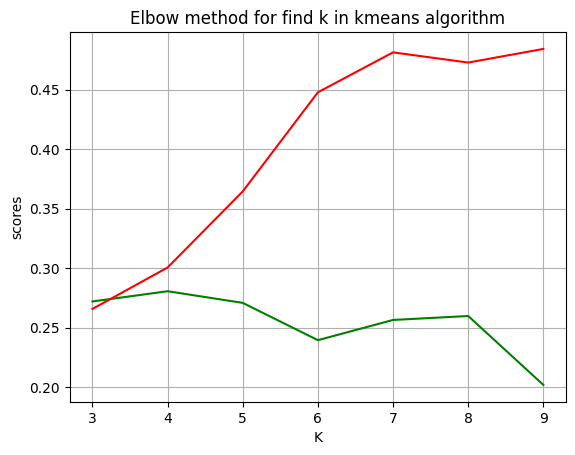

In [23]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
silhouette_scores = []
homo_scores = []
k_s = []
for i in tqdm(range(3,10)):
    k_s.append(i)
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_assignments = kmeans.fit_predict(document_vectors)

    predicted_labels = cluster_assignments
    silhouette_scores.append(silhouette_score(document_vectors,predicted_labels))
    homo_scores.append(homogeneity_score(true_labels,predicted_labels))

plt.plot(k_s,silhouette_scores , color='green', label='silhouette_score')
plt.plot(k_s,homo_scores , color='red', label='homogeneity_score')
plt.grid(True)
plt.ylabel("scores")
plt.xlabel("K")
plt.title("Elbow method for find k in kmeans algorithm")
plt.plot()

#DBSCAN

In [33]:
from sklearn.cluster import DBSCAN
dbscan_pred_labels = DBSCAN(eps=1.6, min_samples=12).fit_predict(document_vectors)

In [34]:

from tabulate import tabulate

table = [["homogeneity", "kmeans", homogeneity_score(true_labels,predicted_labels)], ["silhouette", "kmeans", silhouette_score(document_vectors,predicted_labels)]
         ,["homogeneity", "DBSCAN", homogeneity_score(true_labels,dbscan_pred_labels)], ["silhouette", "DBSCAN", silhouette_score(document_vectors,dbscan_pred_labels)]]
headers = ["metric", "algorithm", "score"]
print(tabulate(table, headers, tablefmt="pretty"))

+-------------+-----------+---------------------+
|   metric    | algorithm |        score        |
+-------------+-----------+---------------------+
| homogeneity |  kmeans   |  0.484111159735134  |
| silhouette  |  kmeans   | 0.20191138982772827 |
| homogeneity |  DBSCAN   | 0.04842222197146812 |
| silhouette  |  DBSCAN   | 0.03896249830722809 |
+-------------+-----------+---------------------+


100%|██████████| 17/17 [00:41<00:00,  2.45s/it]


[]

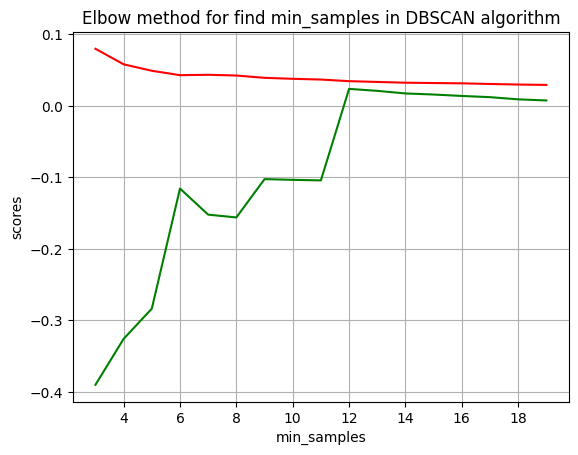

In [26]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
silhouette_scores = []
homo_scores = []
d_s = []
for i in tqdm(range(3,20)):
    d_s.append(i)
    dbscan_pred_labels = DBSCAN(eps=1, min_samples=i).fit_predict(document_vectors)
    silhouette_scores.append(silhouette_score(document_vectors,dbscan_pred_labels))
    homo_scores.append(homogeneity_score(true_labels,dbscan_pred_labels))

plt.plot(d_s,silhouette_scores , color='green', label='silhouette_score')
plt.plot(d_s,homo_scores , color='red', label='homogeneity_score')
plt.grid(True)
plt.ylabel("scores")
plt.xlabel("min_samples")
plt.title("Elbow method for find min_samples in DBSCAN algorithm")
plt.plot()

100%|██████████| 15/15 [01:11<00:00,  4.80s/it]


[]

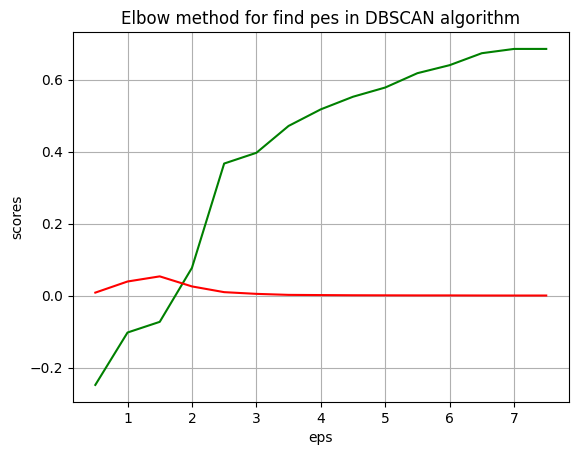

In [27]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
silhouette_scores = []
homo_scores = []
d_s = []
eps_list = []
i = 0.5
while(i<8):
  eps_list.append(i)
  i+=0.5
for i in tqdm(eps_list):
    d_s.append(i)
    dbscan_pred_labels = DBSCAN(eps=i, min_samples=9).fit_predict(document_vectors)
    silhouette_scores.append(silhouette_score(document_vectors,dbscan_pred_labels))
    homo_scores.append(homogeneity_score(true_labels,dbscan_pred_labels))

plt.plot(d_s,silhouette_scores , color='green', label='silhouette_score')
plt.plot(d_s,homo_scores , color='red', label='homogeneity_score')
plt.grid(True)
plt.ylabel("scores")
plt.xlabel("eps")
plt.title("Elbow method for find pes in DBSCAN algorithm")
plt.plot()

#Q3

I say some resoans that we use embedding based on its properties.

**Compatibility**
Numeric representation can be used for k-mean and DBSCAN algorithm(and all machine larning algorith =m taht text are input) because these algorithms get number as input.

**Semantic Representation**
Embeddings capture semantic relationships, ensuring words or documents with similar meanings are represented nearby in a dense vector space.

**Dimensionality Reduction**
Embeddings provide lower-dimensional representations, reducing computational complexity and addressing the curse of dimensionality in high-dimensional text data.

**Improved Generalization**
Embeddings enhance the model's ability to generalize to unseen data by learning meaningful and context-aware representations.



#Q4
Word2vec uses two methods to create word embeddings. Given the data it can make embeddings using words next to each other while considering relations. Word2vec uses two architectures, CBOW and Skip-Gram. In CBOW we choose a word as target and other near words as context and predict the target using context word vectors. Skip-Gram however does the opposite. It takes a word as input and tries to predict context words around it. It makes use of a sliding windows. The size of the windows is a hyperparamether. In the project I got better results with smaller windows sizes. The way Doc2Vec works is almost the same. It tries to find a fixed size feature vector for documents instead of words. In their CBOW for doc2vec they added a matrix for each documents that is used beside words to predict the target word. This way the document vector will also train. In their modified skip-gram, they give document vector as input and try to predict the words in the document.

#Q5
**Clustering Approach**

K-means:

Divides the dataset into a predefined number of clusters (k) based on the mean of data points within each cluster.
Assumes clusters are spherical and equally sized.
Sensitive to initial cluster centers and may converge to local optima.

DBSCAN:
Identifies clusters based on the density of data points in a neighborhood.
Can find clusters of arbitrary shapes and sizes.
Doesn't require the number of clusters to be specified beforehand.

**Cluster Shape and Size**

K-means:

Assumes clusters to be spherical and equally sized.
Sensitive to outliers.

DBSCAN:
Can identify clusters of arbitrary shapes and sizes.
Robust to outliers as noise points.

**Noise Handling**

K-means:

Sensitive to outliers and may consider them as separate clusters.

DBSCAN:
Identifies noise points as outliers and doesn't assign them to any cluster.

**Parameter Dependency**

K-means:

Requires the number of clusters (k) to be specified in advance.
Sensitive to the initial placement of cluster centroids.
DBSCAN:

Automatically determines the number of clusters based on the data density.
Parameters include epsilon (radius of neighborhood) and minPoints (minimum number of points in a neighborhood).

**Use Cases**

K-means:

Well-suited for datasets with well-defined spherical clusters.
Works well when the assumption of equally sized clusters is reasonable.
DBSCAN:

Effective for datasets with clusters of varying shapes and sizes.
Suitable for datasets with irregular densities and noise.

**Scalability**

K-means:

Generally more scalable for large datasets.
DBSCAN:

Can be computationally expensive for very large datasets, especially in high-dimensional spaces.

#Q6
K-mean give us k clusters.
DBSCAN unknown number of clusters and some outliers.
Number of clusters depend on exp and min points.

# **PCA**

#Q7

**Standardize the Data**

Begin by standardizing the dataset to ensure each feature contributes equally to the variance. This involves subtracting the mean and dividing by the standard deviation for each feature.

**Apply PCA**
Utilize PCA to transform the standardized data into principal components. These components are uncorrelated variables capturing the maximum variance in the dataset.

PCA is a linear transformation used to compress data while maintaining the information in the original data. It uses variance in each feature among all the vectors. Feature with the most variance has the most imformation. The result of PCA is a compressed vector each containing some percent of variance of original vector.

**Select Principal Components**
Choose a subset of the principal components based on the amount of variance they capture. A common approach is to select components that achieve a certain cumulative variance threshold.

**Apply K-means on Reduced Dimensions**
Use the selected principal components as input for the K-means clustering algorithm. This step reduces the dimensionality of the data, making it more manageable for clustering.

**Visualize Clusters**
Plot the data points in the reduced-dimensional space, typically using a scatter plot. Assign colors or markers to points based on their assigned clusters by the K-means algorithm.

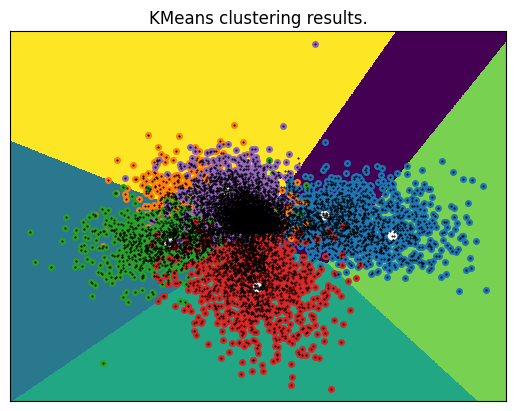

In [50]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
reduced_vectors = PCA(n_components=2).fit_transform(document_vectors)

x_min, x_max = reduced_vectors[:, 0].min() - 1, reduced_vectors[:, 0].max() + 1
y_min, y_max = reduced_vectors[:, 1].min() - 1, reduced_vectors[:, 1].max() + 1
grided_x, grided_y = np.meshgrid(np.arange(x_min, x_max, 0.03), np.arange(y_min, y_max, 0.03))

kmeans = KMeans(n_clusters=6)
kmeans.fit(reduced_vectors)
labels = kmeans.predict(np.c_[grided_x.ravel(), grided_y.ravel()])
labels = labels.reshape(grided_x.shape)
plt.figure(1)
plt.clf()
colors = list(mcolors.TABLEAU_COLORS.keys())
for i, color in enumerate(colors):
    plt.scatter(reduced_vectors[true_labels == i+1, 0], reduced_vectors[true_labels == i+1, 1], marker='o',s=16)

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0],centroids[:,1],color="white")
plt.imshow(
    labels,
    interpolation="nearest",
    extent=(grided_x.min(), grided_x.max(), grided_y.min(), grided_y.max()),
    aspect="auto",
    origin="lower",
)
plt.plot(reduced_vectors[:, 0], reduced_vectors[:, 1], "k.", markersize=2)

plt.xlim(x_min, x_max)
plt.title("KMeans clustering results.")
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


{0, 1, 2, 3, 4, 5, 6, -1}


[]

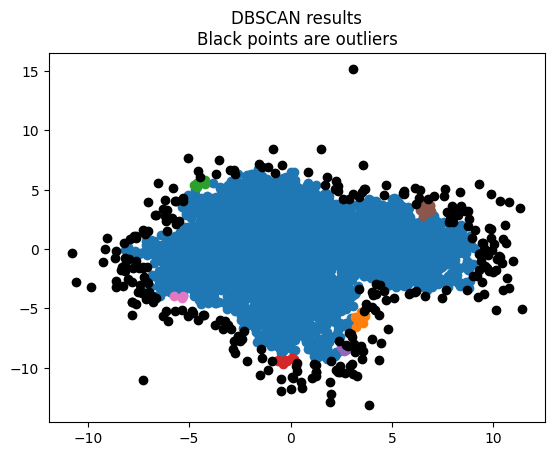

In [44]:
dbscan_colors = list(mcolors.TABLEAU_COLORS.keys())
labels = DBSCAN(eps=0.48,min_samples=7).fit_predict(reduced_vectors)
unique_labels = set(labels)
print(unique_labels)
OUTLIER = -1
for i,c in enumerate(unique_labels):
    if (c != OUTLIER):
        plt.scatter(reduced_vectors[labels == c,0],reduced_vectors[labels == c,1],c = dbscan_colors[i])

    else:
        plt.scatter(reduced_vectors[labels == c,0],reduced_vectors[labels == c,1],color="black")
plt.title("DBSCAN results\nBlack points are outliers")
plt.plot()








#Q8

**Silhouette**

s = (b - a) / max(a , b)


The Silhouette Coefficient is defined for each sample and is composed of two scores:
a: The mean distance between a sample and all other points in the same cluster.
b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample. The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.



**Homogeneity**

H = 1 - (H(Y|C)/(H(Y))

Homogeneity is a metric used to evaluate the quality of clusters in a clustering algorithm. In the context of clustering, homogeneity measures the degree to which all the elements within a cluster belong to the same class or category. In other words, it assesses how well a cluster contains data points that are members of a single class or group.

H(Y∣C) is the conditional entropy of the class labels given the cluster assignments.

H(Y) is the entropy of the class labels.

#Q9
I putted plots and tayble for analysis these metrices.

#Q10
As i do , we can use elbow method to find important parameters of each algorithm .
For example K in kmeans or eps and min_samples in DBSCAN.

Paramters with better reulst on model would produce higher performance.

Also we can do better preprocesses on data based on our data's properties.
For example if another language used we can translate those words or numbers that are not in persian.



In [54]:
%%shell
jupyter nbconvert --to html /content/AI_CA6_810100194.ipynb

[NbConvertApp] Converting notebook /content/AI_CA6_810100194.ipynb to html
[NbConvertApp] Writing 945122 bytes to /content/AI_CA6_810100194.html
